<a href="https://colab.research.google.com/github/claudio1975/10DataScienceProjects/blob/master/05_02_05_03_GBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Number of Claims Estimation with Gradient Boosting Machine (GBM)**

Gradient Boosting Machine is based on ensemble approach. 
Trees are built sequentially: each tree is grown using information from the previous grown trees.
It starts building a model from the training data, then is added a new model to correct the errors made by the previous one, and new models are added sequentially until no further improvements can be made. 

References:

-["Case Study: French Motor Third-Party Liability Claims"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3164764), Mario V. Wuthrich, Alexander Noll, Robert Salzmann;

-["Data Analytics for Non-Life Insurance Pricing"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2870308), Mario V. Wuthrich, Christoph Buser;

-["Statistical Foundations of Actuarial Learning and its Applications"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3822407), Mario V. Wuthrich, Michael Merz

# Upload Libraries

In [ ]:
!pip install h2o

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177.2 MB 47 kB/s 
  Created wheel for h2o: filename=h2o-3.38.0.1-py2.py3-none-any.whl size=177276478 sha256=19ed4eff9dc3a1c4f8721f26c218049f88508a222072bdac9d23f0c20d1848eb
  Stored in directory: /root/.cache/pip/wheels/a1/a1/d9/bb37df368c4635a707e7362d1088450b606041f05aeba5f173
Successfully built h2o


In [ ]:
# handling datasets
import numpy as np
import pandas as pd
# plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# modelling, evaluation
import sklearn
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import h2o
from h2o.estimators import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


# Upload File

In [ ]:
from google.colab import files 
uploaded = files.upload()

Saving swmotorcycle_ClaimNb.csv to swmotorcycle_ClaimNb.csv


In [ ]:
# Reading File
df = pd.read_csv('swmotorcycle_ClaimNb.csv')

# Data Set Overview

In [ ]:
# Dimensions of data set
print(df.shape)

(64548, 8)


In [ ]:
# List types for each attribute
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64548 entries, 0 to 64547
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   OwnerAge    64548 non-null  int64  
 1   Gender      64548 non-null  object 
 2   Area        64548 non-null  object 
 3   RiskClass   64548 non-null  object 
 4   VehAge      64548 non-null  int64  
 5   BonusClass  64548 non-null  object 
 6   Exposure    64548 non-null  float64
 7   ClaimNb     64548 non-null  int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 3.9+ MB
None


In [ ]:
# Take a peek at the first rows of the data
df.head()

,OwnerAge,Gender,Area,RiskClass,VehAge,BonusClass,Exposure,ClaimNb
0,0,Male,Central parts of Sweden's three largest cities,EV ratio 13-15,12,BM1,0.175342,0
1,4,Male,Lesser towns except Gotland; Northern towns,EV ratio 20-24,9,BM1,0.000000,0
2,5,Female,Lesser towns except Gotland; Northern towns,EV ratio 9-12,18,BM1,0.454795,0
3,5,Female,Small towns; countryside except Gotland; North...,EV ratio <5,25,BM1,0.172603,0
4,6,Female,Suburbs; middle-sized cities,EV ratio <5,26,BM1,0.180822,0


# Summary Statistics

In [ ]:
# Summarize attribute distributions for data type of variables
obj_cols = [var for var in df.columns if df[var].dtype=='object']
df[obj_cols].describe().T

,count,unique,top,freq
Gender,64548,2,Male,54695
Area,64548,7,Small towns; countryside except Gotland; North...,24816
RiskClass,64548,7,EV ratio 9-12,18905
BonusClass,64548,7,BM7,17953


In [ ]:
# Summarize attribute distributions for data type of variables
no_obj_cols = [var for var in df.columns if df[var].dtype!='object']
df[no_obj_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
OwnerAge,64548.0,42.416062,12.980960,0.0,31.000000,44.000000,52.0,92.00000
VehAge,64548.0,12.540063,9.727445,0.0,5.000000,12.000000,16.0,99.00000
Exposure,64548.0,1.010671,1.307424,0.0,0.463014,0.827397,1.0,31.33973
ClaimNb,64548.0,0.010798,0.107323,0.0,0.000000,0.000000,0.0,2.00000


# Data Cleaning

In [ ]:
# get number of unique values for each column
counts = df.nunique()
# record columns to delete
to_del = [i for i,v in enumerate(counts) if v == 1]
print(to_del)
# drop useless columns
df.drop(to_del, axis=1, inplace=True)
print(df.shape)

[]
(64548, 8)


In [ ]:
# get number of unique values for each row
counts = df.duplicated()
# record rows to delete
to_del = [i for i,v in enumerate(counts) if v == 1]
print(to_del)
print(df.shape)

[]
(64548, 8)


In [ ]:
# Check missing values both to numeric features and categorical features 
missing = df.isnull().sum()/df.shape[0]*100
missing

OwnerAge      0.0
Gender        0.0
Area          0.0
RiskClass     0.0
VehAge        0.0
BonusClass    0.0
Exposure      0.0
ClaimNb       0.0
dtype: float64

In [ ]:
# Feature transformation
df_1 = df.copy()
df_1['Exposure'] = df_1['Exposure'].clip(upper=1)
df_1['VehAge'] = df_1['VehAge'].clip(upper=20)

# Pre-Processing

In [ ]:
# Split dataset
df_train, df_test, = train_test_split(df_1, train_size=0.8, test_size=0.2,random_state=0)

In [ ]:
h2o.init(nthreads=-1,max_mem_size = "12G")

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.16" 2022-07-19; OpenJDK Runtime Environment (build 11.0.16+8-post-Ubuntu-0ubuntu118.04); OpenJDK 64-Bit Server VM (build 11.0.16+8-post-Ubuntu-0ubuntu118.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpy8q361sj
  JVM stdout: /tmp/tmpy8q361sj/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpy8q361sj/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.1
H2O_cluster_version_age:,19 days
H2O_cluster_name:,H2O_from_python_unknownUser_98469x
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,12 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [ ]:
# Convert Pandas data frame into H2O data frame
train = h2o.H2OFrame(df_train)
test = h2o.H2OFrame(df_test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
# Input 
predictors = ['Gender','RiskClass','Area','BonusClass','OwnerAge','VehAge']
# offset
train["offset"] = train["Exposure"].log()
test["offset"] = test["Exposure"].log()
# Output 
response = 'ClaimNb'

# Modelling 1

In [ ]:
# Define model
GBM_model_1 = H2OGradientBoostingEstimator(offset_column = "offset", distribution="poisson", nfolds=5, categorical_encoding='auto',seed=0)

# Train model
GBM1 = GBM_model_1.train(x=predictors, y=response, training_frame=train)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


In [ ]:
# summary of the model
print(GBM1)

Model Details
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1665263200673_1


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          22942                  5            5            5             31            32            31.84

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.010408497778151527
RMSE: 0.10202204554973168
MAE: 0.018876752832314193
RMSLE: 0.06896645731336305
Mean Residual Deviance: 0.09383354168471425

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.011728045903044756
RMSE: 0.1082961028986951
MAE: 0.01954907109081289
RMSLE: 0.0738604920655774
Mean Residual Deviance: 0.1

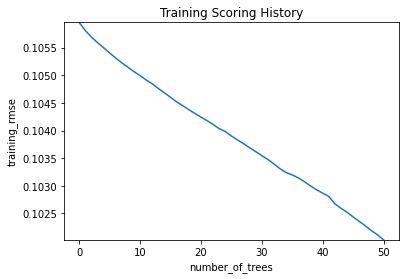

In [ ]:
# plot training history
GBM1.plot()

# Model Evaluation 1

In [ ]:
# Eval performance:
perf_train_1 = GBM1.model_performance(train)
pred_train_1 = GBM1.predict(train)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [ ]:
perf_train_1

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.010408497789244655
RMSE: 0.10202204560409801
MAE: 0.018876753700879507
RMSLE: 0.06896645749550273
Mean Residual Deviance: 0.09383354096860282

In [ ]:
# Eval performance:
perf_test_1 = GBM1.model_performance(test)
pred_test_1 = GBM1.predict(test)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [ ]:
perf_test_1

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.01312212836577
RMSE: 0.11455185884903832
MAE: 0.02081020347197128
RMSLE: 0.07717426295192831
Mean Residual Deviance: 0.1355863553144911

In [ ]:
# replace H2O data frame with a pandas data frame
predictions_tr_1 = pred_train_1.as_data_frame()
predictions_te_1 = pred_test_1.as_data_frame()

In [ ]:
mean_tr_1 = predictions_tr_1.mean()
mean_te_1 = predictions_te_1.mean()

In [ ]:
# replaced 0 values with the mean because "mean poisson deviance" is strictly positive 
predictions_tr_1 = predictions_tr_1.replace(0, mean_tr_1)
predictions_te_1 = predictions_te_1.replace(0, mean_te_1)


In [ ]:
mean_poisson_deviance(df_train.ClaimNb,predictions_tr_1)

0.07223674416705307

In [ ]:
mean_poisson_deviance(df_test.ClaimNb,predictions_te_1)

0.11830431394652079

In [ ]:
np.sqrt(mean_squared_error(df_train.ClaimNb, predictions_tr_1))

0.10202963487192426

In [ ]:
np.sqrt(mean_squared_error(df_test.ClaimNb, predictions_te_1))

0.1145651284237595

# Modelling 2

In [ ]:
# Input 
predictors_ = ['RiskClass','Area','BonusClass','OwnerAge','VehAge']

In [ ]:
# Define model
GBM_model_2 = H2OGradientBoostingEstimator(offset_column = "offset", distribution="poisson", nfolds=5, categorical_encoding='auto',seed=0)

# Train model
GBM2 = GBM_model_2.train(x=predictors_, y=response, training_frame=train)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


In [ ]:
# summary of the model
print(GBM2)

Model Details
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1665263200673_2


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          22557                  5            5            5             26            32            31.24

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.010406249106543445
RMSE: 0.10201102443630024
MAE: 0.018810939052031267
RMSLE: 0.06898849981359095
Mean Residual Deviance: 0.09389387251383283

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.011586462226238731
RMSE: 0.10764043025851733
MAE: 0.019608500201957944
RMSLE: 0.07353782505090813
Mean Residual Deviance: 

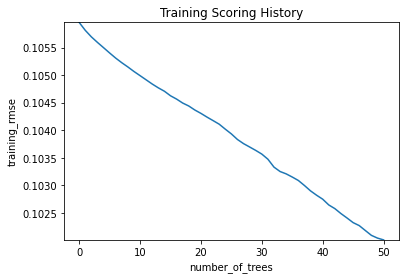

In [ ]:
# plot training history
GBM2.plot()

# Model evaluation 2

In [ ]:
# Eval performance:
perf_train_2 = GBM2.model_performance(train)
pred_train_2 = GBM2.predict(train)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [ ]:
perf_train_2

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.010406249115583707
RMSE: 0.10201102448061046
MAE: 0.018810939520680737
RMSLE: 0.06898849982758341
Mean Residual Deviance: 0.09389387158622384

In [ ]:
# Eval performance:
perf_test_2 = GBM2.model_performance(test)
pred_test_2 = GBM2.predict(test)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [ ]:
perf_test_2

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.012896099493212883
RMSE: 0.1135609945941514
MAE: 0.020580199356156285
RMSLE: 0.07695356426010573
Mean Residual Deviance: 0.13201982870789183

In [ ]:
# replace H2O data frame with a pandas data frame
predictions_tr_2 = pred_train_2.as_data_frame()
predictions_te_2 = pred_test_2.as_data_frame()

In [ ]:
mean_tr_2 = predictions_tr_2.mean()
mean_te_2 = predictions_te_2.mean()

In [ ]:
# replaced 0 values with the mean because "mean poisson deviance" is strictly positive 
predictions_tr_2 = predictions_tr_2.replace(0, mean_tr_1)
predictions_te_2 = predictions_te_2.replace(0, mean_te_1)

In [ ]:
mean_poisson_deviance(df_train.ClaimNb,predictions_tr_2)

0.07229707480947554

In [ ]:
mean_poisson_deviance(df_test.ClaimNb,predictions_te_2)

0.11045259753520158

In [ ]:
np.sqrt(mean_squared_error(df_train.ClaimNb, predictions_tr_2))

0.10201861456830949

In [ ]:
np.sqrt(mean_squared_error(df_test.ClaimNb, predictions_te_2))

0.11357437993753423

# Modelling 3

In [ ]:
train_, valid = train.split_frame(ratios = [0.9], seed = 0)

In [ ]:
# define range of hyper-params for the grid search
gbm_params = {'ntrees':[10,20],
              'learn_rate':[0.01, 0.1],
              'max_depth': [3, 5, 9]}


In [ ]:
# set up the grid search and define the model
GBM_model_tuning = H2OGridSearch(H2OGradientBoostingEstimator(offset_column = "offset", distribution="poisson", nfolds=5, categorical_encoding='auto',seed=0),
                           grid_id ='GBM_model_tuning',
                           hyper_params = gbm_params)


In [ ]:
# Train model
GBMTuning = GBM_model_tuning.train(x=predictors_, y=response, training_frame=train_, validation_frame=valid)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


In [ ]:
# Get the grid results, sorted by validation Mean Residual Deviance
GBM_gridperf = GBMTuning.get_grid(sort_by='residual_deviance', decreasing=False)
GBM_gridperf

,learn_rate,max_depth,ntrees,model_ids,residual_deviance
,0.1,3.0,20.0,GBM_model_tuning_model_8,0.1121799
,0.1,3.0,10.0,GBM_model_tuning_model_2,0.1144932
,0.1,5.0,10.0,GBM_model_tuning_model_4,0.1171957
,0.01,5.0,20.0,GBM_model_tuning_model_9,0.1200425
,0.01,3.0,20.0,GBM_model_tuning_model_7,0.1203576
,0.1,5.0,20.0,GBM_model_tuning_model_10,0.1208549
,0.01,5.0,10.0,GBM_model_tuning_model_3,0.1214249
,0.01,3.0,10.0,GBM_model_tuning_model_1,0.1216425
,0.01,9.0,10.0,GBM_model_tuning_model_5,0.1289302
,0.01,9.0,20.0,GBM_model_tuning_model_11,0.1414638


In [ ]:
# Define model
GBM_model_3 = H2OGradientBoostingEstimator(ntrees = 20, learn_rate = 0.10, max_depth = 3, nfolds=5, categorical_encoding='auto',seed=0)

# Train model
GBM3 = GBM_model_3.train(x=predictors_, y=response, training_frame=train_, validation_frame=valid)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


In [ ]:
# summary of the model
print(GBM3)

Model Details
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1665263200673_3


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    20                 20                          3170                   3            3            3             8             8             8

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.011014368645053913
RMSE: 0.1049493622898868
MAE: 0.020516796047275878
RMSLE: 0.0707580509004955
Mean Residual Deviance: 0.011014368645053913

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 0.011060845765063587
RMSE: 0.10517055559929113
MAE: 0.02080639756926606
RMSLE: 0.07206229363792982
Mean Residual Deviance: 0.0110608457

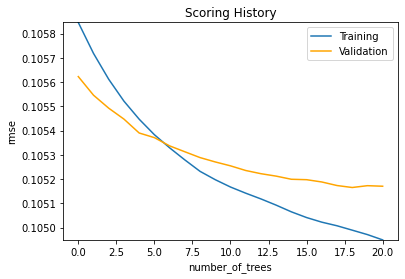

In [ ]:
# plot training history
GBM3.plot()

# Model Evaluation 3

In [ ]:
# Eval performance:
perf_train_3 = GBM3.model_performance(train)
pred_train_3 = GBM3.predict(train)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [ ]:
perf_train_3

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.011019078640353803
RMSE: 0.10497179926224853
MAE: 0.020546144013084727
RMSLE: 0.07089131561140213
Mean Residual Deviance: 0.011019078640353803

In [ ]:
# Eval performance:
perf_test_3 = GBM3.model_performance(test)
pred_test_3 = GBM3.predict(test)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [ ]:
perf_test_3

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.012669894407368579
RMSE: 0.11256062547520149
MAE: 0.021776974030833632
RMSLE: 0.07554574474834445
Mean Residual Deviance: 0.012669894407368579

In [ ]:
# replace H2O data frame with a pandas data frame
predictions_tr_3 = pred_train_3.as_data_frame()
predictions_te_3 = pred_test_3.as_data_frame()

In [ ]:
mean_poisson_deviance(df_train.ClaimNb,predictions_tr_3)

0.0859188407748982

In [ ]:
mean_poisson_deviance(df_test.ClaimNb,predictions_te_3)

0.0968469477412595

In [ ]:
np.sqrt(mean_squared_error(df_train.ClaimNb, predictions_tr_3))

0.10497179926225027

In [ ]:
np.sqrt(mean_squared_error(df_test.ClaimNb, predictions_te_3))

0.11256062547520232

# **GBM Results Analysis**

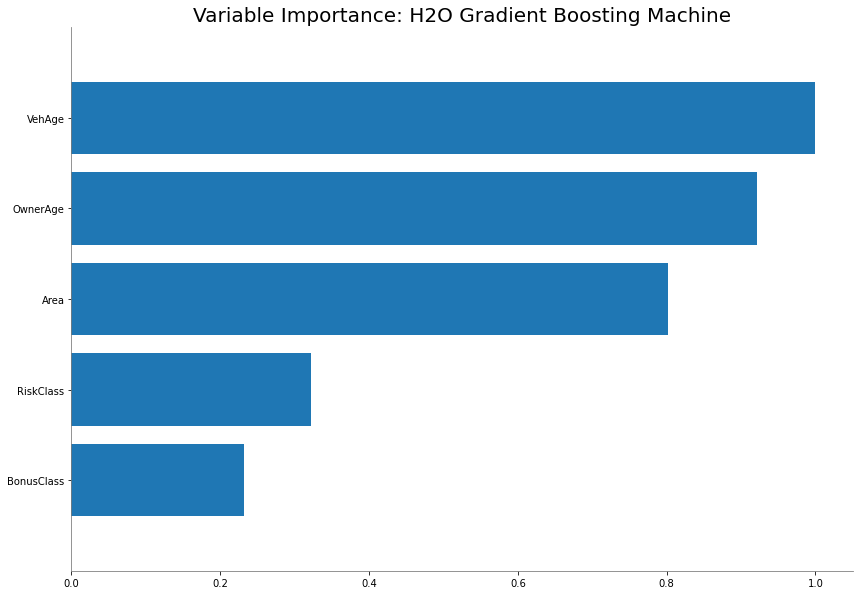

<Figure size 720x360 with 0 Axes>

In [ ]:
# Feature Importance
GBM3.varimp_plot()

In [ ]:
predictions_te_3 = predictions_te_3.rename(columns = {'predict':'ClaimNb_pred'})
test = pd.concat([df_test, predictions_te_3.set_index(df_test.index)], axis=1)
test

,OwnerAge,Gender,Area,RiskClass,VehAge,BonusClass,Exposure,ClaimNb,ClaimNb_pred
11551,28,Female,Small towns; countryside except Gotland; North...,EV ratio 20-24,13,BM3,0.419178,0,0.015433
27696,42,Female,Suburbs; middle-sized cities,EV ratio <5,4,BM7,0.983562,0,0.012516
56213,57,Male,Lesser towns except Gotland; Northern towns,EV ratio 13-15,16,BM7,1.000000,0,0.005784
8463,26,Male,Central parts of Sweden's three largest cities,EV ratio 13-15,13,BM1,0.986301,0,0.016556
35448,45,Male,Small towns; countryside except Gotland; North...,EV ratio 20-24,4,BM6,0.986301,0,0.009700
...,...,...,...,...,...,...,...,...,...
15776,31,Female,Lesser towns except Gotland; Northern towns,EV ratio 13-15,15,BM7,0.989041,0,0.007085
43435,49,Male,Small towns; countryside except Gotland; North...,EV ratio 13-15,11,BM7,1.000000,0,0.008510
50162,53,Male,Suburbs; middle-sized cities,EV ratio 9-12,6,BM7,1.000000,0,0.011229
2912,22,Male,Suburbs; middle-sized cities,EV ratio 16-19,8,BM1,0.630137,0,0.029555


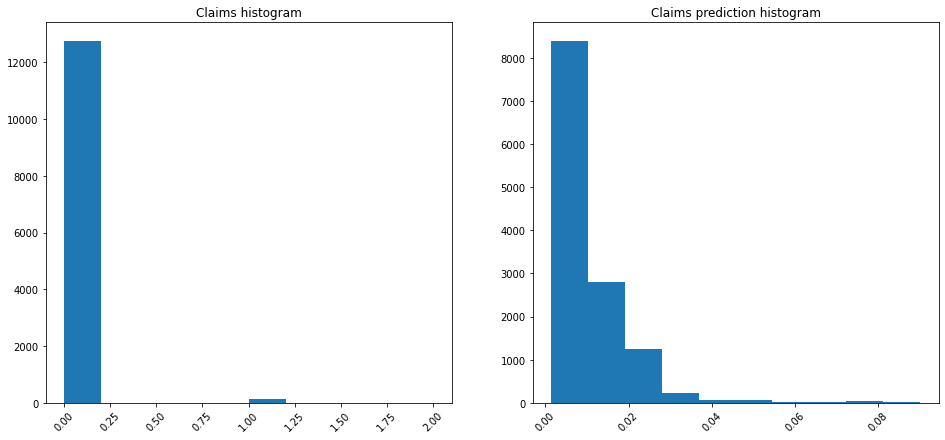

In [ ]:
# Claims comparison
fig = plt.figure(figsize = (16,7))
plt.subplot(1,2,1)  
plt.hist(test['ClaimNb'], bins=10)
plt.xticks(rotation=45)
plt.title('Claims histogram')
plt.subplot(1,2,2)  
plt.hist(test['ClaimNb_pred'], bins=10)
plt.xticks(rotation=45)
plt.title('Claims prediction histogram')
plt.show()

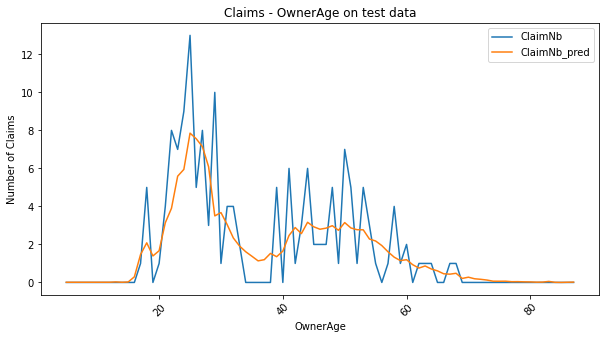

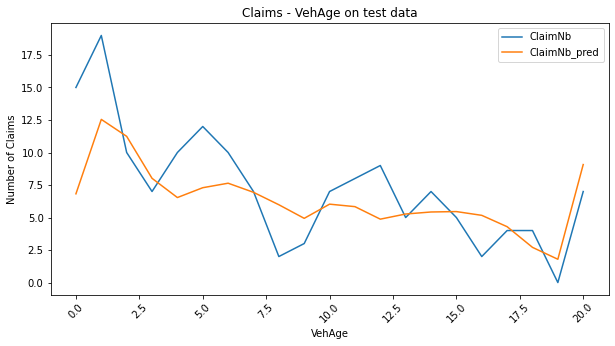

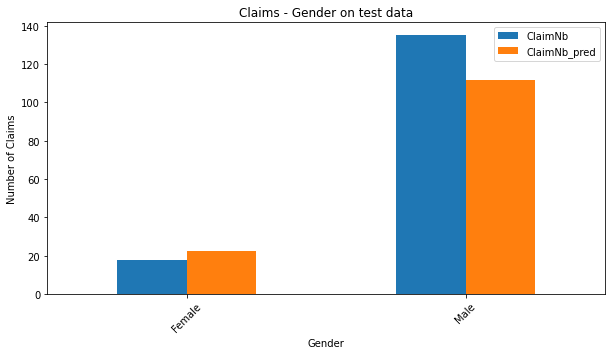

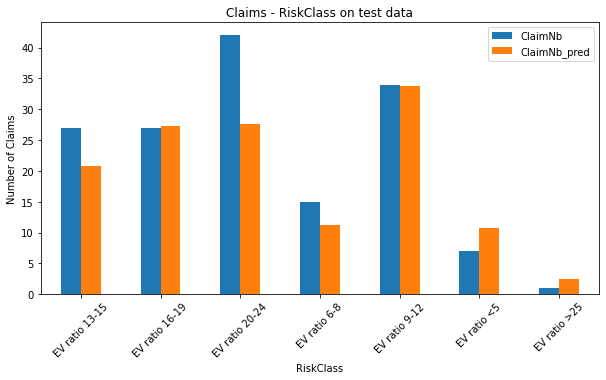

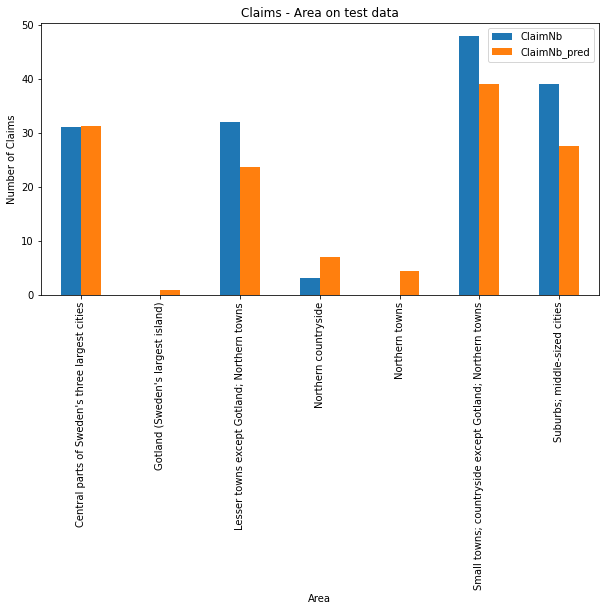

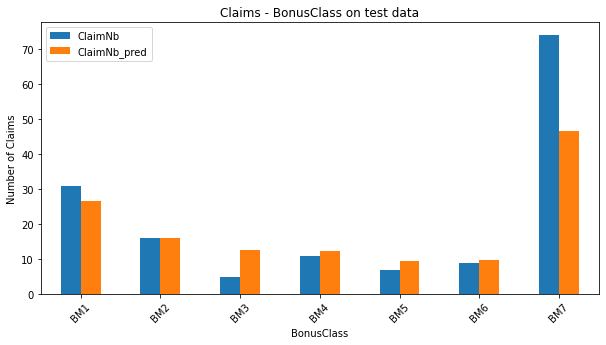

In [ ]:
# Claims and claims predicted comparison on features
plt.rcParams["figure.figsize"] = (10,5)
test_group_oa = test.groupby(['OwnerAge'])['ClaimNb','ClaimNb_pred'].sum().reset_index()
test_group_oa.plot(x='OwnerAge',y= ['ClaimNb','ClaimNb_pred'])
plt.xticks(rotation=45)
plt.ylabel('Number of Claims')
plt.xlabel('OwnerAge')
plt.title('Claims - OwnerAge on test data')
plt.show()
test_group_va = test.groupby(['VehAge'])['ClaimNb','ClaimNb_pred'].sum().reset_index()
test_group_va.plot(x='VehAge',y= ['ClaimNb','ClaimNb_pred'])
plt.xticks(rotation=45)
plt.ylabel('Number of Claims')
plt.xlabel('VehAge')
plt.title('Claims - VehAge on test data')
plt.show()
test_group_ge = test.groupby(['Gender'])['ClaimNb','ClaimNb_pred'].sum().reset_index()
test_group_ge.plot.bar(x='Gender',y= ['ClaimNb','ClaimNb_pred'])
plt.xticks(rotation=45)
plt.ylabel('Number of Claims')
plt.xlabel('Gender')
plt.title('Claims - Gender on test data')
plt.show()
test_group_rc = test.groupby(['RiskClass'])['ClaimNb','ClaimNb_pred'].sum().reset_index()
test_group_rc.plot.bar(x='RiskClass',y= ['ClaimNb','ClaimNb_pred'])
plt.xticks(rotation=45)
plt.ylabel('Number of Claims')
plt.xlabel('RiskClass')
plt.title('Claims - RiskClass on test data')
plt.show()
test_group_a = test.groupby(['Area'])['ClaimNb','ClaimNb_pred'].sum().reset_index()
test_group_a.plot.bar(x='Area',y= ['ClaimNb','ClaimNb_pred'])
plt.xticks(rotation=90)
plt.ylabel('Number of Claims')
plt.xlabel('Area')
plt.title('Claims - Area on test data')
plt.show()
test_group_bc = test.groupby(['BonusClass'])['ClaimNb','ClaimNb_pred'].sum().reset_index()
test_group_bc.plot.bar(x='BonusClass',y= ['ClaimNb','ClaimNb_pred'])
plt.xticks(rotation=45)
plt.ylabel('Number of Claims')
plt.xlabel('BonusClass')
plt.title('Claims - BonusClass on test data')
plt.show()
